In [3]:
import torch

from torch_geometric.datasets import KarateClub, Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

data = dataset[0]
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        #torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)

        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
        #return x

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

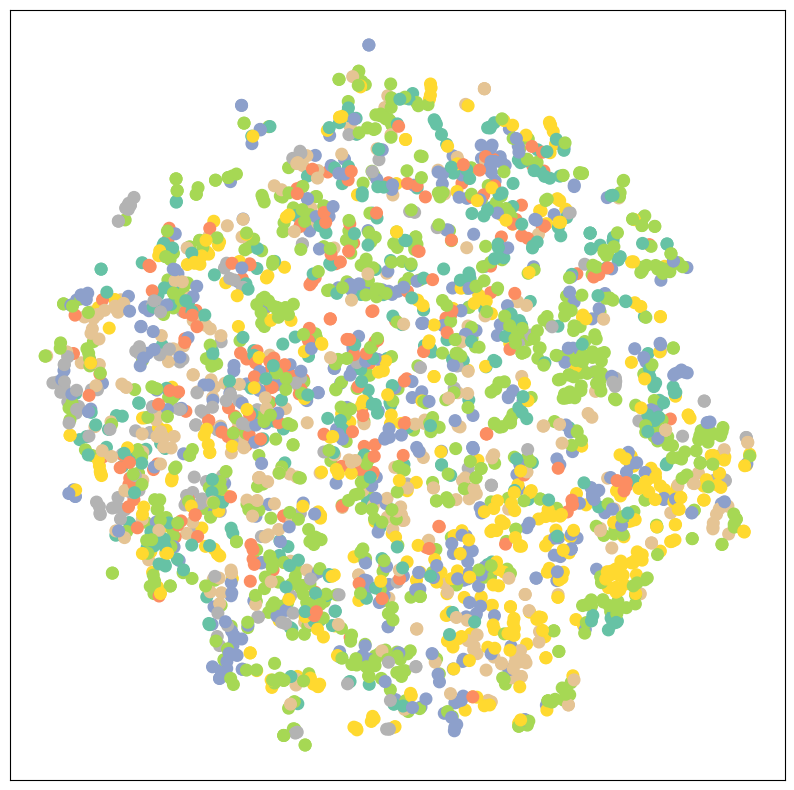

In [6]:
learn_rate = 0.01
num_epoch = 200
runs = 10

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = GCN(hidden_channels=16).to(device)

model.eval()

out = model(data.x.to(device), data.edge_index.to(device))
visualize(out, color=data.y)

In [1120]:
def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x.to(device), data.edge_index.to(device))
      loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
      loss.backward()
      optimizer.step()
      return loss

def val():
    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = criterion(out[data.val_mask], data.y[data.val_mask].to(device))
    return loss.item()


def test(mask):
      model.eval()
      out = model(data.x.to(device), data.edge_index.to(device))
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask].to(device)
      acc = int(correct.sum()) / int(mask.sum())
      return acc

for run in range(runs):
      max_acc = 0
      min_loss = 20

      model.conv1.reset_parameters()
      model.conv2.reset_parameters()

      optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=5e-4)
      criterion = torch.nn.CrossEntropyLoss()

      for epoch in range(1, num_epoch + 1):
            loss = train()
            val_loss = val()

            val_acc = test(data.val_mask)
            test_acc = test(data.test_mask)

            if(test_acc > max_acc):
                  max_acc = test_acc
            if(val_loss < min_loss):
                  min_loss = val_loss

            
      print(f'Run: {run:02d}, Loss: {min_loss:.4f}, Test: {max_acc:.4f}')

Run: 00, Loss: 0.8260, Test: 0.8140
Run: 01, Loss: 0.8025, Test: 0.8230
Run: 02, Loss: 0.8147, Test: 0.8240
Run: 03, Loss: 0.8295, Test: 0.8120
Run: 04, Loss: 0.8195, Test: 0.8160
Run: 05, Loss: 0.8101, Test: 0.8190
Run: 06, Loss: 0.8065, Test: 0.8170
Run: 07, Loss: 0.7934, Test: 0.8250
Run: 08, Loss: 0.8148, Test: 0.8240
Run: 09, Loss: 0.8466, Test: 0.8130


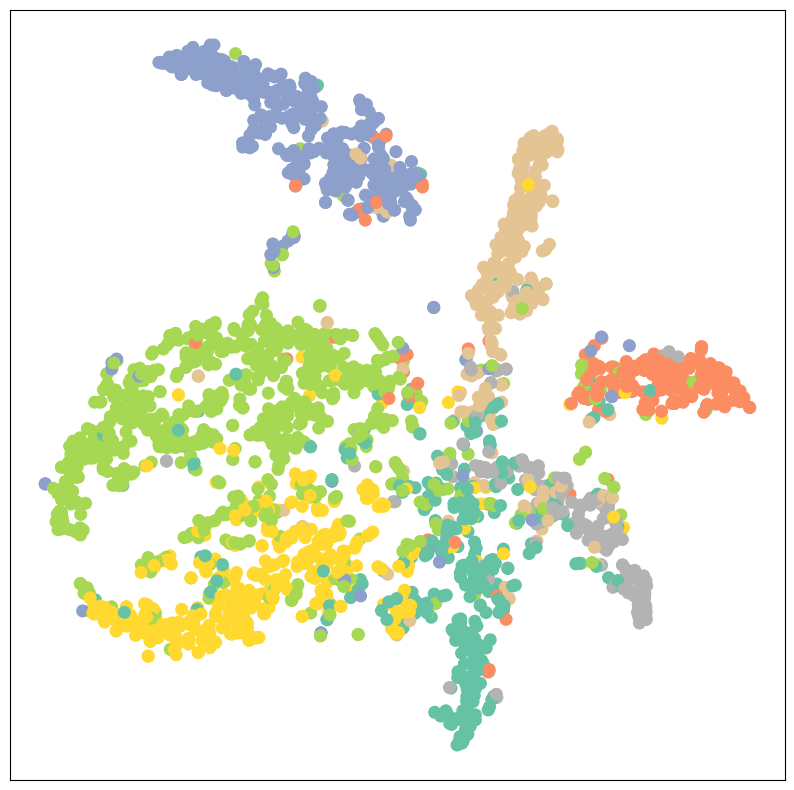

In [1121]:
model.eval()

out = model(data.x.to(device), data.edge_index.to(device))
visualize(out, color=data.y)